In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import os
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned



/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ticker         = params.ticker
features_cols  = params.features_cols
label_col      = params.label_col
look_back      = params.look_back 

save_path = Path(params.save_path)
in_path   = save_path / f"{ticker}_ready.csv"
out_path  = save_path / f"{ticker}_final.csv"

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

Using device: cuda


In [3]:
# create the _final.csv from the _ready.csv (if the _ready has been modified today or if the _final hasn´t been created yet)

def was_modified_today(path: Path) -> bool:
    """
    Return True if path exists AND its modification date is exactly today.
    """
    if not path.exists():
        return False

    # get the file's last‐modified timestamp, convert to a date
    mtime     = path.stat().st_mtime
    file_date = dt.datetime.fromtimestamp(mtime).date()

    # compare to today's date
    return file_date == dt.date.today()


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build your features and return a cleaned DataFrame.
    """
    # 1) intraday log‐returns
    for lag in (1, 5, 15):
        df[f"r_{lag}"] = np.log(df["close"] / df["close"].shift(lag))

    # 2) volatility & volume spikes
    df["vol_15"]       = df["r_1"].rolling(15).std()
    df["volume_spike"] = df["volume"] / df["volume"].rolling(15).mean()

    # 3) VWAP deviation
    typ_price     = (df["high"] + df["low"] + df["close"]) / 3
    vwap          = (typ_price * df["volume"]).cumsum() \
                    / df["volume"].cumsum()
    df["vwap_dev"] = (df["close"] - vwap) / vwap

    # 4) 14‐period RSI
    delta     = df["close"].diff()
    gain      = delta.clip(lower=0)
    loss      = -delta.clip(upper=0)
    avg_gain  = gain.rolling(14).mean()
    avg_loss  = loss.rolling(14).mean()
    rs        = avg_gain / avg_loss
    df["rsi_14"] = 100 - (100 / (1 + rs))

    # 5) filter down to your features + bid/ask + label
    df = df[features_cols + ["bid", "ask", label_col]].dropna()
    return df


# ─── Decide whether to rebuild or just load ────────────────────────────────
# Rebuild if:
#   - final CSV isn't there, OR
#   - the "ready" CSV was modified today
if (not out_path.exists()) or was_modified_today(in_path):
    print(f"→ Running feature_engineering on {in_path.name}")
    raw = pd.read_csv(in_path, index_col=0, parse_dates=True)
    df  = feature_engineering(raw)
    print(f"→ Saving enriched data to {out_path.name}")
    df.to_csv(out_path)
else:
    print(f"→ {out_path.name} is up‐to‐date; loading")
    df = pd.read_csv(out_path, index_col=0, parse_dates=True)

df  # now ready for downstream use


→ Running feature_engineering on GOOGL_ready.csv
→ Saving enriched data to GOOGL_final.csv


,open,high,low,close,volume,r_1,r_5,r_15,vol_15,volume_spike,vwap_dev,rsi_14,bid,ask,signal_smooth
2014-04-03 12:06:00,28.644845,28.644845,28.644845,28.644845,4580.0,-0.000180,-0.000180,-0.000180,0.000046,0.568641,-0.000177,0.000000,28.636251,28.653438,0.162925
2014-04-03 12:07:00,28.639690,28.639690,28.639690,28.639690,4540.0,-0.000180,-0.000360,-0.000360,0.000063,0.570338,-0.000352,0.000000,28.631098,28.648282,0.164530
2014-04-03 12:08:00,28.634534,28.634534,28.634534,28.634534,4500.0,-0.000180,-0.000540,-0.000540,0.000075,0.574408,-0.000524,0.000000,28.625944,28.643125,0.166141
2014-04-03 12:09:00,28.629379,28.629379,28.629379,28.629379,4460.0,-0.000180,-0.000720,-0.000720,0.000082,0.581017,-0.000694,0.000000,28.620791,28.637968,0.167757
2014-04-03 12:10:00,28.624224,28.624224,28.624224,28.624224,4420.0,-0.000180,-0.000900,-0.000900,0.000088,0.590413,-0.000862,0.000000,28.615637,28.632811,0.169381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17 20:56:00,176.090000,176.160000,176.010000,176.050000,126589.0,-0.000284,-0.000681,-0.001297,0.000443,1.610125,1.217786,39.325843,175.997200,176.102800,0.000000
2025-06-17 20:57:00,176.050000,176.080000,175.890000,175.930000,125176.0,-0.000682,-0.000398,-0.001761,0.000469,1.478464,1.216271,34.328358,175.877200,175.982800,0.000000
2025-06-17 20:58:00,175.930000,175.975000,175.860000,175.890000,200235.0,-0.000227,-0.001023,-0.002016,0.000468,2.096227,1.215761,29.648241,175.837200,175.942800,0.000000
2025-06-17 20:59:00,175.900000,175.970000,175.800000,175.930000,393414.0,0.000227,-0.001136,-0.002073,0.000464,3.295458,1.216254,25.925926,175.877200,175.982800,0.000000


In [4]:
# ──────────────────────────────────────────────────────────────────────────────
# Build LSTM input tensors (disk-backed memmaps)
#    Returns five tensors on `device`:
#      X        : (N, look_back, F)
#      y        : (N,)
#      raw_close: (N,)
#      raw_bid  : (N,)
#      raw_ask  : (N,)
# ──────────────────────────────────────────────────────────────────────────────
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df             = df,
    look_back      = look_back,
    features_cols  = features_cols,
    label_col      = label_col,
    regular_start  = params.regular_start_pred
)

print("Shapes:")
print("  X         =", X.shape,    "(samples, features, look_back)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

Shapes:
  X         = torch.Size([1174595, 120, 12]) (samples, features, look_back)
  y         = torch.Size([1174595]) (samples,)
  raw_close = torch.Size([1174595])
  raw_bid   = torch.Size([1174595])
  raw_ask   = torch.Size([1174595])


In [5]:
# ──────────────────────────────────────────────────────────────────────────────
#    (We use the helper `chronological_split` that returns)
#      (X_tr, y_tr),
#      (X_val, y_val),
#      (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te)
# ──────────────────────────────────────────────────────────────────────────────
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back       = look_back,
    regular_start   = params.regular_start_pred,
    train_prop      = params.train_prop,
    val_prop        = params.val_prop,
    train_batch     = params.hparams['TRAIN_BATCH']
)

print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)


Shapes:
  X_tr        = torch.Size([793001, 120, 12])
  y_tr        = torch.Size([793001])
  raw_close_te= torch.Size([190594])
  raw_bid_te  = torch.Size([190594])
  raw_ask_te  = torch.Size([190594])


In [14]:
# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"\nBaseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=793001, val=191000, te=190594
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..374], total days=375
   te_day_id  ∈ [0..372], total days=373
4) instantiating DayWindowDatasets
   ds_tr days: 1744
   ds_val days: 375
   ds_te days: 373
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready

Baseline (zero‐forecast) RMSE on validation = 0.383251


In [15]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────
def objective_train(trial):
    # Sample only the knobs you care about
    hp = {
        # Architecture
        "SHORT_UNITS"          : trial.suggest_int  ("SHORT_UNITS",    16, 128),
        "LONG_UNITS"           : trial.suggest_int  ("LONG_UNITS",     32, 256),
        "DROPOUT_SHORT"        : trial.suggest_float("DROPOUT_SHORT",  0.0, 0.5),
        "DROPOUT_LONG"         : trial.suggest_float("DROPOUT_LONG",   0.0, 0.5),
        "ATT_HEADS"            : trial.suggest_int  ("ATT_HEADS",      1,   8),
        "ATT_DROPOUT"          : trial.suggest_float("ATT_DROPOUT",    0.0, 0.5),

        # Optimizer & scheduler
        "INITIAL_LR"           : trial.suggest_loguniform("INITIAL_LR",     1e-5, 1e-2),
        "WEIGHT_DECAY"         : trial.suggest_loguniform("WEIGHT_DECAY",   1e-6, 1e-2),
        "CLIPNORM"             : trial.suggest_float("CLIPNORM",       0.0, 1.0),
        "LR_EPOCHS_WARMUP"     : trial.suggest_int  ("LR_EPOCHS_WARMUP", 1,   10),
        "EARLY_STOP_PATIENCE"  : trial.suggest_int  ("EARLY_STOP_PATIENCE", 2, 20),
    }

    # immediately prune if embed_dim % heads != 0
    if hp["SHORT_UNITS"] % hp["ATT_HEADS"] != 0:
        # this trial is nonsense—stop right away
        raise TrialPruned()

    # Build model
    model = models.DualMemoryLSTM(
        n_feats       = len(features_cols),
        short_units   = hp["SHORT_UNITS"],
        long_units    = hp["LONG_UNITS"],
        dropout_short = hp["DROPOUT_SHORT"],
        dropout_long  = hp["DROPOUT_LONG"],
        att_heads     = hp["ATT_HEADS"],
        att_drop      = hp["ATT_DROPOUT"],
    ).to(device)

    # Build optimizer + schedulers + scaler
    optimizer, plateau_sched, cosine_sched, scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )

    # Run training & return best validation RMSE
    best_rmse = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams["MAX_EPOCHS"],
        early_stop_patience = hp["EARLY_STOP_PATIENCE"],
        baseline_val_rmse   = baseline_val_rmse,
        clipnorm            = clipnorm,
        device              = device,
    )
    return best_rmse



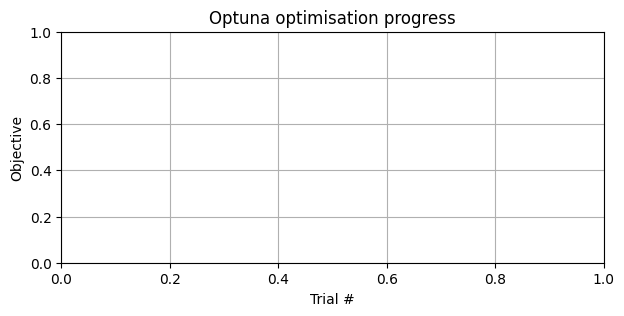

In [16]:
# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 3))
line,   = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimisation progress", xlim=(0, 1), ylim=(0, 1))
ax.grid(True)

handle = display(fig, display_id=True)   # show once and keep handle
plt.close(fig)                           # <── prevents the duplicate static copy


[I 2025-07-21 17:38:58,589] A new study created in memory with name: no-name-4c650dcb-5746-4895-b417-a8b7527ab5e1
/tmp/ipykernel_7114/3761965960.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "INITIAL_LR"           : trial.suggest_loguniform("INITIAL_LR",     1e-5, 1e-2),
/tmp/ipykernel_7114/3761965960.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "WEIGHT_DECAY"         : trial.suggest_loguniform("WEIGHT_DECAY",   1e-6, 1e-2),
[I 2025-07-21 17:38:58,591] Trial 0 pruned. 
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.wa

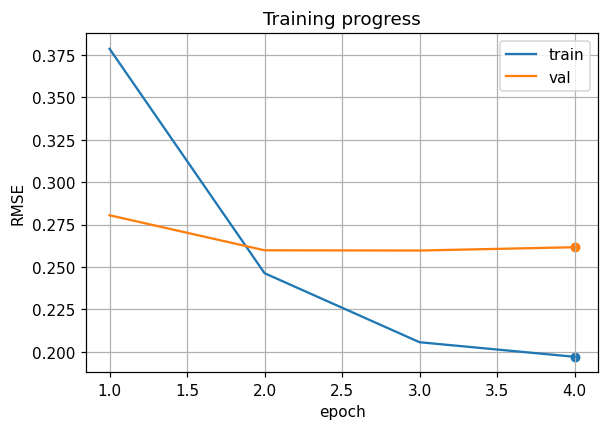

Epoch 1:   2%|▏         | 2/109 [00:02<00:47,  2.26bundle/s, lr=4.78e-5, train_rmse=0.639]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 1


Epoch 1:   3%|▎         | 3/109 [00:03<00:45,  2.35bundle/s, lr=4.78e-5, train_rmse=0.626]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 2


Epoch 1:   4%|▎         | 4/109 [00:03<00:42,  2.47bundle/s, lr=4.78e-5, train_rmse=0.617]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 3


Epoch 1:   5%|▍         | 5/109 [00:03<00:40,  2.55bundle/s, lr=4.78e-5, train_rmse=0.605]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 4


Epoch 1:   6%|▌         | 6/109 [00:04<00:40,  2.57bundle/s, lr=4.78e-5, train_rmse=0.593]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 5


Epoch 1:   6%|▋         | 7/109 [00:04<00:39,  2.55bundle/s, lr=4.78e-5, train_rmse=0.582]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 6


Epoch 1:   7%|▋         | 8/109 [00:05<00:39,  2.58bundle/s, lr=4.78e-5, train_rmse=0.57] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 7


Epoch 1:   8%|▊         | 9/109 [00:05<00:38,  2.59bundle/s, lr=4.78e-5, train_rmse=0.56]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 8


Epoch 1:   9%|▉         | 10/109 [00:05<00:38,  2.60bundle/s, lr=4.78e-5, train_rmse=0.551]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 9


Epoch 1:  10%|█         | 11/109 [00:06<00:37,  2.61bundle/s, lr=4.78e-5, train_rmse=0.543]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 10


Epoch 1:  11%|█         | 12/109 [00:06<00:36,  2.63bundle/s, lr=4.78e-5, train_rmse=0.536]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 11


Epoch 1:  12%|█▏        | 13/109 [00:06<00:35,  2.68bundle/s, lr=4.78e-5, train_rmse=0.529]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 12


Epoch 1:  13%|█▎        | 14/109 [00:07<00:36,  2.58bundle/s, lr=4.78e-5, train_rmse=0.523]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 13


Epoch 1:  14%|█▍        | 15/109 [00:07<00:37,  2.52bundle/s, lr=4.78e-5, train_rmse=0.517]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 14


Epoch 1:  15%|█▍        | 16/109 [00:08<00:36,  2.53bundle/s, lr=4.78e-5, train_rmse=0.511]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 15


Epoch 1:  16%|█▌        | 17/109 [00:08<00:35,  2.58bundle/s, lr=4.78e-5, train_rmse=0.507]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 16


Epoch 1:  17%|█▋        | 18/109 [00:08<00:35,  2.59bundle/s, lr=4.78e-5, train_rmse=0.503]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 17


Epoch 1:  17%|█▋        | 19/109 [00:09<00:34,  2.60bundle/s, lr=4.78e-5, train_rmse=0.5]  

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 18


Epoch 1:  18%|█▊        | 20/109 [00:09<00:34,  2.61bundle/s, lr=4.78e-5, train_rmse=0.496]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 19


Epoch 1:  19%|█▉        | 21/109 [00:10<00:33,  2.62bundle/s, lr=4.78e-5, train_rmse=0.492]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 20


Epoch 1:  20%|██        | 22/109 [00:10<00:33,  2.63bundle/s, lr=4.78e-5, train_rmse=0.488]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 21


Epoch 1:  21%|██        | 23/109 [00:10<00:32,  2.67bundle/s, lr=4.78e-5, train_rmse=0.485]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 22


Epoch 1:  22%|██▏       | 24/109 [00:11<00:32,  2.65bundle/s, lr=4.78e-5, train_rmse=0.482]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 23


Epoch 1:  23%|██▎       | 25/109 [00:11<00:31,  2.65bundle/s, lr=4.78e-5, train_rmse=0.48] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 24


Epoch 1:  24%|██▍       | 26/109 [00:12<00:32,  2.57bundle/s, lr=4.78e-5, train_rmse=0.477]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 25


Epoch 1:  25%|██▍       | 27/109 [00:12<00:32,  2.56bundle/s, lr=4.78e-5, train_rmse=0.475]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 26


Epoch 1:  26%|██▌       | 28/109 [00:12<00:31,  2.56bundle/s, lr=4.78e-5, train_rmse=0.472]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 27


Epoch 1:  27%|██▋       | 29/109 [00:13<00:31,  2.57bundle/s, lr=4.78e-5, train_rmse=0.469]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 28


Epoch 1:  28%|██▊       | 30/109 [00:13<00:30,  2.58bundle/s, lr=4.78e-5, train_rmse=0.466]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 29


Epoch 1:  28%|██▊       | 31/109 [00:13<00:29,  2.62bundle/s, lr=4.78e-5, train_rmse=0.464]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 30


Epoch 1:  29%|██▉       | 32/109 [00:14<00:29,  2.60bundle/s, lr=4.78e-5, train_rmse=0.462]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 31


Epoch 1:  30%|███       | 33/109 [00:14<00:29,  2.55bundle/s, lr=4.78e-5, train_rmse=0.459]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 32


Epoch 1:  31%|███       | 34/109 [00:15<00:29,  2.54bundle/s, lr=4.78e-5, train_rmse=0.457]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 33


Epoch 1:  32%|███▏      | 35/109 [00:15<00:29,  2.54bundle/s, lr=4.78e-5, train_rmse=0.455]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 34


Epoch 1:  33%|███▎      | 36/109 [00:15<00:29,  2.50bundle/s, lr=4.78e-5, train_rmse=0.453]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 35


Epoch 1:  34%|███▍      | 37/109 [00:16<00:29,  2.47bundle/s, lr=4.78e-5, train_rmse=0.451]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 36


Epoch 1:  35%|███▍      | 38/109 [00:16<00:28,  2.47bundle/s, lr=4.78e-5, train_rmse=0.448]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 37


Epoch 1:  36%|███▌      | 39/109 [00:17<00:28,  2.43bundle/s, lr=4.78e-5, train_rmse=0.446]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 38


Epoch 1:  37%|███▋      | 40/109 [00:17<00:28,  2.46bundle/s, lr=4.78e-5, train_rmse=0.445]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 39


Epoch 1:  38%|███▊      | 41/109 [00:17<00:27,  2.46bundle/s, lr=4.78e-5, train_rmse=0.443]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 40


Epoch 1:  39%|███▊      | 42/109 [00:18<00:27,  2.45bundle/s, lr=4.78e-5, train_rmse=0.441]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 41


Epoch 1:  39%|███▉      | 43/109 [00:18<00:26,  2.48bundle/s, lr=4.78e-5, train_rmse=0.439]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 42


Epoch 1:  40%|████      | 44/109 [00:19<00:26,  2.50bundle/s, lr=4.78e-5, train_rmse=0.437]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 43


Epoch 1:  41%|████▏     | 45/109 [00:19<00:25,  2.51bundle/s, lr=4.78e-5, train_rmse=0.436]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 44


Epoch 1:  42%|████▏     | 46/109 [00:19<00:24,  2.54bundle/s, lr=4.78e-5, train_rmse=0.434]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 45


Epoch 1:  43%|████▎     | 47/109 [00:20<00:25,  2.42bundle/s, lr=4.78e-5, train_rmse=0.432]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 46


Epoch 1:  44%|████▍     | 48/109 [00:20<00:25,  2.41bundle/s, lr=4.78e-5, train_rmse=0.431]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 47


Epoch 1:  45%|████▍     | 49/109 [00:21<00:24,  2.41bundle/s, lr=4.78e-5, train_rmse=0.43] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 48


Epoch 1:  46%|████▌     | 50/109 [00:21<00:26,  2.25bundle/s, lr=4.78e-5, train_rmse=0.428]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 49


Epoch 1:  47%|████▋     | 51/109 [00:22<00:25,  2.28bundle/s, lr=4.78e-5, train_rmse=0.427]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 50


Epoch 1:  48%|████▊     | 52/109 [00:22<00:24,  2.34bundle/s, lr=4.78e-5, train_rmse=0.425]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 51


Epoch 1:  49%|████▊     | 53/109 [00:22<00:23,  2.40bundle/s, lr=4.78e-5, train_rmse=0.424]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 52


Epoch 1:  50%|████▉     | 54/109 [00:23<00:22,  2.39bundle/s, lr=4.78e-5, train_rmse=0.423]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 53


Epoch 1:  50%|█████     | 55/109 [00:23<00:22,  2.44bundle/s, lr=4.78e-5, train_rmse=0.421]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 54


Epoch 1:  51%|█████▏    | 56/109 [00:24<00:21,  2.47bundle/s, lr=4.78e-5, train_rmse=0.42] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 55
  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 56


Epoch 1:  53%|█████▎    | 58/109 [00:24<00:13,  3.88bundle/s, lr=4.78e-5, train_rmse=0.417]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 57


Epoch 1:  54%|█████▍    | 59/109 [00:24<00:14,  3.44bundle/s, lr=4.78e-5, train_rmse=0.416]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 58


Epoch 1:  55%|█████▌    | 60/109 [00:25<00:15,  3.16bundle/s, lr=4.78e-5, train_rmse=0.415]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 59


Epoch 1:  56%|█████▌    | 61/109 [00:25<00:16,  2.98bundle/s, lr=4.78e-5, train_rmse=0.414]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 60


Epoch 1:  57%|█████▋    | 62/109 [00:25<00:16,  2.86bundle/s, lr=4.78e-5, train_rmse=0.413]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 61


Epoch 1:  58%|█████▊    | 63/109 [00:26<00:16,  2.79bundle/s, lr=4.78e-5, train_rmse=0.412]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 62


Epoch 1:  59%|█████▊    | 64/109 [00:26<00:16,  2.68bundle/s, lr=4.78e-5, train_rmse=0.411]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 63


Epoch 1:  60%|█████▉    | 65/109 [00:27<00:16,  2.63bundle/s, lr=4.78e-5, train_rmse=0.409]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 64


Epoch 1:  61%|██████    | 66/109 [00:27<00:16,  2.60bundle/s, lr=4.78e-5, train_rmse=0.408]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 65


Epoch 1:  61%|██████▏   | 67/109 [00:27<00:16,  2.56bundle/s, lr=4.78e-5, train_rmse=0.407]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 66


Epoch 1:  62%|██████▏   | 68/109 [00:28<00:16,  2.53bundle/s, lr=4.78e-5, train_rmse=0.405]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 67


Epoch 1:  63%|██████▎   | 69/109 [00:28<00:16,  2.50bundle/s, lr=4.78e-5, train_rmse=0.404]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 68


Epoch 1:  64%|██████▍   | 70/109 [00:29<00:16,  2.43bundle/s, lr=4.78e-5, train_rmse=0.403]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 69


Epoch 1:  65%|██████▌   | 71/109 [00:29<00:16,  2.31bundle/s, lr=4.78e-5, train_rmse=0.401]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 70


Epoch 1:  66%|██████▌   | 72/109 [00:30<00:15,  2.34bundle/s, lr=4.78e-5, train_rmse=0.4]  

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 71


Epoch 1:  67%|██████▋   | 73/109 [00:30<00:15,  2.39bundle/s, lr=4.78e-5, train_rmse=0.399]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 72


Epoch 1:  68%|██████▊   | 74/109 [00:30<00:14,  2.48bundle/s, lr=4.78e-5, train_rmse=0.397]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 73


Epoch 1:  69%|██████▉   | 75/109 [00:31<00:13,  2.54bundle/s, lr=4.78e-5, train_rmse=0.396]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 74


Epoch 1:  70%|██████▉   | 76/109 [00:31<00:12,  2.55bundle/s, lr=4.78e-5, train_rmse=0.395]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 75


Epoch 1:  71%|███████   | 77/109 [00:31<00:12,  2.56bundle/s, lr=4.78e-5, train_rmse=0.396]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 76


Epoch 1:  72%|███████▏  | 78/109 [00:32<00:12,  2.54bundle/s, lr=4.78e-5, train_rmse=0.397]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 77


Epoch 1:  72%|███████▏  | 79/109 [00:32<00:11,  2.54bundle/s, lr=4.78e-5, train_rmse=0.396]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 78


Epoch 1:  73%|███████▎  | 80/109 [00:33<00:11,  2.54bundle/s, lr=4.78e-5, train_rmse=0.395]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 79


Epoch 1:  74%|███████▍  | 81/109 [00:33<00:11,  2.54bundle/s, lr=4.78e-5, train_rmse=0.394]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 80


Epoch 1:  75%|███████▌  | 82/109 [00:33<00:10,  2.58bundle/s, lr=4.78e-5, train_rmse=0.393]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 81


Epoch 1:  76%|███████▌  | 83/109 [00:34<00:09,  2.63bundle/s, lr=4.78e-5, train_rmse=0.392]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 82


Epoch 1:  77%|███████▋  | 84/109 [00:34<00:09,  2.65bundle/s, lr=4.78e-5, train_rmse=0.391]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 83


Epoch 1:  78%|███████▊  | 85/109 [00:35<00:09,  2.62bundle/s, lr=4.78e-5, train_rmse=0.39] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 84


Epoch 1:  79%|███████▉  | 86/109 [00:35<00:08,  2.58bundle/s, lr=4.78e-5, train_rmse=0.389]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 85


Epoch 1:  80%|███████▉  | 87/109 [00:35<00:08,  2.58bundle/s, lr=4.78e-5, train_rmse=0.389]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 86


Epoch 1:  81%|████████  | 88/109 [00:36<00:08,  2.58bundle/s, lr=4.78e-5, train_rmse=0.388]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 87


Epoch 1:  82%|████████▏ | 89/109 [00:36<00:07,  2.60bundle/s, lr=4.78e-5, train_rmse=0.387]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 88


Epoch 1:  83%|████████▎ | 90/109 [00:36<00:07,  2.58bundle/s, lr=4.78e-5, train_rmse=0.387]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 89


Epoch 1:  83%|████████▎ | 91/109 [00:37<00:07,  2.57bundle/s, lr=4.78e-5, train_rmse=0.386]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 90


Epoch 1:  84%|████████▍ | 92/109 [00:37<00:06,  2.57bundle/s, lr=4.78e-5, train_rmse=0.386]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 91


Epoch 1:  85%|████████▌ | 93/109 [00:38<00:06,  2.56bundle/s, lr=4.78e-5, train_rmse=0.385]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 92


Epoch 1:  86%|████████▌ | 94/109 [00:38<00:05,  2.53bundle/s, lr=4.78e-5, train_rmse=0.384]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 93


Epoch 1:  87%|████████▋ | 95/109 [00:38<00:05,  2.51bundle/s, lr=4.78e-5, train_rmse=0.384]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 94


Epoch 1:  88%|████████▊ | 96/109 [00:39<00:05,  2.50bundle/s, lr=4.78e-5, train_rmse=0.383]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 95


Epoch 1:  89%|████████▉ | 97/109 [00:39<00:04,  2.52bundle/s, lr=4.78e-5, train_rmse=0.382]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 96


Epoch 1:  90%|████████▉ | 98/109 [00:40<00:04,  2.56bundle/s, lr=4.78e-5, train_rmse=0.381]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 97


Epoch 1:  91%|█████████ | 99/109 [00:40<00:03,  2.56bundle/s, lr=4.78e-5, train_rmse=0.381]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 98


Epoch 1:  92%|█████████▏| 100/109 [00:40<00:03,  2.56bundle/s, lr=4.78e-5, train_rmse=0.38]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 99


Epoch 1:  93%|█████████▎| 101/109 [00:41<00:03,  2.56bundle/s, lr=4.78e-5, train_rmse=0.38]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 100


Epoch 1:  94%|█████████▎| 102/109 [00:41<00:02,  2.56bundle/s, lr=4.78e-5, train_rmse=0.379]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 101


Epoch 1:  94%|█████████▍| 103/109 [00:42<00:02,  2.59bundle/s, lr=4.78e-5, train_rmse=0.379]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 102


Epoch 1:  95%|█████████▌| 104/109 [00:42<00:01,  2.63bundle/s, lr=4.78e-5, train_rmse=0.379]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 103


Epoch 1:  96%|█████████▋| 105/109 [00:42<00:01,  2.58bundle/s, lr=4.78e-5, train_rmse=0.379]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 104


Epoch 1:  97%|█████████▋| 106/109 [00:43<00:01,  2.57bundle/s, lr=4.78e-5, train_rmse=0.379]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 105


Epoch 1:  98%|█████████▊| 107/109 [00:43<00:00,  2.57bundle/s, lr=4.78e-5, train_rmse=0.379]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 106


Epoch 1:  99%|█████████▉| 108/109 [00:44<00:00,  2.57bundle/s, lr=4.78e-5, train_rmse=0.379]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 107


Epoch 1: 100%|██████████| 109/109 [00:44<00:00,  2.45bundle/s, lr=4.78e-5, train_rmse=0.379]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 1, batch 108


Epoch 001 • train=0.3786 • val=0.2805 • lr=4.78e-05


Epoch 2:   1%|          | 1/109 [00:00<00:23,  4.59bundle/s, lr=4.78e-5, train_rmse=0.367]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 0


Epoch 2:   2%|▏         | 2/109 [00:01<00:33,  3.15bundle/s, lr=4.78e-5, train_rmse=0.371]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 1


Epoch 2:   3%|▎         | 3/109 [00:01<00:36,  2.88bundle/s, lr=4.78e-5, train_rmse=0.375]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 2


Epoch 2:   4%|▎         | 4/109 [00:01<00:37,  2.77bundle/s, lr=4.78e-5, train_rmse=0.377]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 3


Epoch 2:   5%|▍         | 5/109 [00:02<00:38,  2.68bundle/s, lr=4.78e-5, train_rmse=0.376]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 4


Epoch 2:   6%|▌         | 6/109 [00:02<00:39,  2.64bundle/s, lr=4.78e-5, train_rmse=0.375]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 5


Epoch 2:   6%|▋         | 7/109 [00:02<00:38,  2.64bundle/s, lr=4.78e-5, train_rmse=0.373]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 6


Epoch 2:   7%|▋         | 8/109 [00:03<00:38,  2.64bundle/s, lr=4.78e-5, train_rmse=0.37] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 7


Epoch 2:   8%|▊         | 9/109 [00:03<00:37,  2.67bundle/s, lr=4.78e-5, train_rmse=0.365]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 8


Epoch 2:   9%|▉         | 10/109 [00:04<00:36,  2.68bundle/s, lr=4.78e-5, train_rmse=0.361]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 9


Epoch 2:  10%|█         | 11/109 [00:04<00:36,  2.67bundle/s, lr=4.78e-5, train_rmse=0.357]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 10


Epoch 2:  11%|█         | 12/109 [00:04<00:36,  2.65bundle/s, lr=4.78e-5, train_rmse=0.352]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 11


Epoch 2:  12%|█▏        | 13/109 [00:05<00:36,  2.65bundle/s, lr=4.78e-5, train_rmse=0.346]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 12


Epoch 2:  13%|█▎        | 14/109 [00:05<00:36,  2.64bundle/s, lr=4.78e-5, train_rmse=0.341]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 13


Epoch 2:  14%|█▍        | 15/109 [00:05<00:35,  2.68bundle/s, lr=4.78e-5, train_rmse=0.335]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 14


Epoch 2:  15%|█▍        | 16/109 [00:06<00:35,  2.65bundle/s, lr=4.78e-5, train_rmse=0.329]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 15


Epoch 2:  16%|█▌        | 17/109 [00:06<00:34,  2.63bundle/s, lr=4.78e-5, train_rmse=0.324]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 16


Epoch 2:  17%|█▋        | 18/109 [00:07<00:34,  2.61bundle/s, lr=4.78e-5, train_rmse=0.32] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 17


Epoch 2:  17%|█▋        | 19/109 [00:07<00:34,  2.61bundle/s, lr=4.78e-5, train_rmse=0.316]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 18
  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 19


Epoch 2:  19%|█▉        | 21/109 [00:07<00:22,  3.95bundle/s, lr=4.78e-5, train_rmse=0.308]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 20


Epoch 2:  20%|██        | 22/109 [00:08<00:25,  3.35bundle/s, lr=4.78e-5, train_rmse=0.305]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 21


Epoch 2:  21%|██        | 23/109 [00:08<00:28,  3.01bundle/s, lr=4.78e-5, train_rmse=0.302]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 22


Epoch 2:  22%|██▏       | 24/109 [00:08<00:29,  2.86bundle/s, lr=4.78e-5, train_rmse=0.3]  

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 23


Epoch 2:  23%|██▎       | 25/109 [00:09<00:32,  2.57bundle/s, lr=4.78e-5, train_rmse=0.299]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 24


Epoch 2:  24%|██▍       | 26/109 [00:09<00:32,  2.53bundle/s, lr=4.78e-5, train_rmse=0.296]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 25


Epoch 2:  25%|██▍       | 27/109 [00:10<00:32,  2.50bundle/s, lr=4.78e-5, train_rmse=0.293]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 26


Epoch 2:  26%|██▌       | 28/109 [00:10<00:32,  2.53bundle/s, lr=4.78e-5, train_rmse=0.291]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 27


Epoch 2:  27%|██▋       | 29/109 [00:11<00:31,  2.56bundle/s, lr=4.78e-5, train_rmse=0.288]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 28


Epoch 2:  28%|██▊       | 30/109 [00:11<00:30,  2.56bundle/s, lr=4.78e-5, train_rmse=0.286]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 29


Epoch 2:  28%|██▊       | 31/109 [00:11<00:30,  2.53bundle/s, lr=4.78e-5, train_rmse=0.284]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 30


Epoch 2:  29%|██▉       | 32/109 [00:12<00:30,  2.50bundle/s, lr=4.78e-5, train_rmse=0.282]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 31


Epoch 2:  30%|███       | 33/109 [00:12<00:30,  2.50bundle/s, lr=4.78e-5, train_rmse=0.28] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 32


Epoch 2:  31%|███       | 34/109 [00:13<00:30,  2.50bundle/s, lr=4.78e-5, train_rmse=0.278]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 33


Epoch 2:  32%|███▏      | 35/109 [00:13<00:29,  2.51bundle/s, lr=4.78e-5, train_rmse=0.276]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 34


Epoch 2:  33%|███▎      | 36/109 [00:13<00:29,  2.51bundle/s, lr=4.78e-5, train_rmse=0.274]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 35


Epoch 2:  34%|███▍      | 37/109 [00:14<00:28,  2.53bundle/s, lr=4.78e-5, train_rmse=0.272]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 36


Epoch 2:  35%|███▍      | 38/109 [00:14<00:28,  2.48bundle/s, lr=4.78e-5, train_rmse=0.27] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 37


Epoch 2:  36%|███▌      | 39/109 [00:15<00:28,  2.43bundle/s, lr=4.78e-5, train_rmse=0.268]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 38


Epoch 2:  37%|███▋      | 40/109 [00:15<00:28,  2.46bundle/s, lr=4.78e-5, train_rmse=0.267]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 39


Epoch 2:  38%|███▊      | 41/109 [00:15<00:27,  2.47bundle/s, lr=4.78e-5, train_rmse=0.265]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 40


Epoch 2:  39%|███▊      | 42/109 [00:16<00:28,  2.38bundle/s, lr=4.78e-5, train_rmse=0.264]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 41


Epoch 2:  39%|███▉      | 43/109 [00:16<00:27,  2.40bundle/s, lr=4.78e-5, train_rmse=0.262]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 42


Epoch 2:  40%|████      | 44/109 [00:17<00:27,  2.39bundle/s, lr=4.78e-5, train_rmse=0.261]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 43


Epoch 2:  41%|████▏     | 45/109 [00:17<00:26,  2.41bundle/s, lr=4.78e-5, train_rmse=0.259]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 44


Epoch 2:  42%|████▏     | 46/109 [00:17<00:25,  2.47bundle/s, lr=4.78e-5, train_rmse=0.258]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 45


Epoch 2:  43%|████▎     | 47/109 [00:18<00:24,  2.50bundle/s, lr=4.78e-5, train_rmse=0.257]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 46


Epoch 2:  44%|████▍     | 48/109 [00:18<00:24,  2.45bundle/s, lr=4.78e-5, train_rmse=0.256]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 47


Epoch 2:  45%|████▍     | 49/109 [00:19<00:24,  2.42bundle/s, lr=4.78e-5, train_rmse=0.255]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 48


Epoch 2:  46%|████▌     | 50/109 [00:19<00:24,  2.39bundle/s, lr=4.78e-5, train_rmse=0.255]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 49


Epoch 2:  47%|████▋     | 51/109 [00:20<00:24,  2.40bundle/s, lr=4.78e-5, train_rmse=0.254]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 50


Epoch 2:  48%|████▊     | 52/109 [00:20<00:23,  2.44bundle/s, lr=4.78e-5, train_rmse=0.253]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 51


Epoch 2:  49%|████▊     | 53/109 [00:20<00:22,  2.50bundle/s, lr=4.78e-5, train_rmse=0.252]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 52


Epoch 2:  50%|████▉     | 54/109 [00:21<00:21,  2.52bundle/s, lr=4.78e-5, train_rmse=0.251]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 53


Epoch 2:  50%|█████     | 55/109 [00:21<00:21,  2.53bundle/s, lr=4.78e-5, train_rmse=0.25] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 54


Epoch 2:  51%|█████▏    | 56/109 [00:21<00:20,  2.53bundle/s, lr=4.78e-5, train_rmse=0.249]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 55


Epoch 2:  52%|█████▏    | 57/109 [00:22<00:20,  2.53bundle/s, lr=4.78e-5, train_rmse=0.248]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 56


Epoch 2:  53%|█████▎    | 58/109 [00:22<00:20,  2.54bundle/s, lr=4.78e-5, train_rmse=0.247]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 57


Epoch 2:  54%|█████▍    | 59/109 [00:23<00:19,  2.54bundle/s, lr=4.78e-5, train_rmse=0.248]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 58


Epoch 2:  55%|█████▌    | 60/109 [00:23<00:19,  2.52bundle/s, lr=4.78e-5, train_rmse=0.247]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 59


Epoch 2:  56%|█████▌    | 61/109 [00:23<00:19,  2.49bundle/s, lr=4.78e-5, train_rmse=0.247]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 60


Epoch 2:  57%|█████▋    | 62/109 [00:24<00:19,  2.37bundle/s, lr=4.78e-5, train_rmse=0.246]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 61


Epoch 2:  58%|█████▊    | 63/109 [00:24<00:18,  2.44bundle/s, lr=4.78e-5, train_rmse=0.246]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 62


Epoch 2:  59%|█████▊    | 64/109 [00:25<00:18,  2.40bundle/s, lr=4.78e-5, train_rmse=0.245]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 63


Epoch 2:  60%|█████▉    | 65/109 [00:25<00:18,  2.44bundle/s, lr=4.78e-5, train_rmse=0.244]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 64


Epoch 2:  61%|██████    | 66/109 [00:26<00:17,  2.48bundle/s, lr=4.78e-5, train_rmse=0.243]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 65


Epoch 2:  61%|██████▏   | 67/109 [00:26<00:16,  2.51bundle/s, lr=4.78e-5, train_rmse=0.242]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 66


Epoch 2:  62%|██████▏   | 68/109 [00:26<00:16,  2.53bundle/s, lr=4.78e-5, train_rmse=0.241]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 67


Epoch 2:  63%|██████▎   | 69/109 [00:27<00:15,  2.55bundle/s, lr=4.78e-5, train_rmse=0.24] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 68


Epoch 2:  64%|██████▍   | 70/109 [00:27<00:15,  2.59bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 69


Epoch 2:  65%|██████▌   | 71/109 [00:27<00:14,  2.61bundle/s, lr=4.78e-5, train_rmse=0.238]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 70


Epoch 2:  66%|██████▌   | 72/109 [00:28<00:14,  2.51bundle/s, lr=4.78e-5, train_rmse=0.238]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 71


Epoch 2:  67%|██████▋   | 73/109 [00:28<00:14,  2.55bundle/s, lr=4.78e-5, train_rmse=0.237]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 72


Epoch 2:  68%|██████▊   | 74/109 [00:29<00:13,  2.57bundle/s, lr=4.78e-5, train_rmse=0.236]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 73


Epoch 2:  69%|██████▉   | 75/109 [00:29<00:13,  2.59bundle/s, lr=4.78e-5, train_rmse=0.235]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 74


Epoch 2:  70%|██████▉   | 76/109 [00:29<00:12,  2.58bundle/s, lr=4.78e-5, train_rmse=0.235]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 75


Epoch 2:  71%|███████   | 77/109 [00:30<00:12,  2.59bundle/s, lr=4.78e-5, train_rmse=0.238]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 76


Epoch 2:  72%|███████▏  | 78/109 [00:30<00:11,  2.60bundle/s, lr=4.78e-5, train_rmse=0.241]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 77


Epoch 2:  72%|███████▏  | 79/109 [00:31<00:12,  2.46bundle/s, lr=4.78e-5, train_rmse=0.241]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 78


Epoch 2:  73%|███████▎  | 80/109 [00:31<00:11,  2.47bundle/s, lr=4.78e-5, train_rmse=0.241]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 79


Epoch 2:  74%|███████▍  | 81/109 [00:31<00:11,  2.48bundle/s, lr=4.78e-5, train_rmse=0.24] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 80


Epoch 2:  75%|███████▌  | 82/109 [00:32<00:11,  2.37bundle/s, lr=4.78e-5, train_rmse=0.24]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 81


Epoch 2:  76%|███████▌  | 83/109 [00:32<00:10,  2.37bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 82


Epoch 2:  77%|███████▋  | 84/109 [00:33<00:10,  2.32bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 83


Epoch 2:  78%|███████▊  | 85/109 [00:33<00:10,  2.37bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 84


Epoch 2:  79%|███████▉  | 86/109 [00:34<00:09,  2.38bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 85


Epoch 2:  80%|███████▉  | 87/109 [00:34<00:09,  2.37bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 86


Epoch 2:  81%|████████  | 88/109 [00:34<00:09,  2.28bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 87


Epoch 2:  82%|████████▏ | 89/109 [00:35<00:09,  2.22bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 88


Epoch 2:  83%|████████▎ | 90/109 [00:35<00:08,  2.20bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 89


Epoch 2:  83%|████████▎ | 91/109 [00:36<00:08,  2.19bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 90


Epoch 2:  84%|████████▍ | 92/109 [00:36<00:07,  2.20bundle/s, lr=4.78e-5, train_rmse=0.24] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 91


Epoch 2:  85%|████████▌ | 93/109 [00:37<00:07,  2.22bundle/s, lr=4.78e-5, train_rmse=0.24]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 92


Epoch 2:  86%|████████▌ | 94/109 [00:37<00:06,  2.27bundle/s, lr=4.78e-5, train_rmse=0.24]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 93


Epoch 2:  87%|████████▋ | 95/109 [00:38<00:06,  2.31bundle/s, lr=4.78e-5, train_rmse=0.24]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 94


Epoch 2:  88%|████████▊ | 96/109 [00:38<00:05,  2.35bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 95


Epoch 2:  89%|████████▉ | 97/109 [00:38<00:05,  2.38bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 96
  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 97


Epoch 2:  91%|█████████ | 99/109 [00:39<00:03,  3.22bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 98


Epoch 2:  92%|█████████▏| 100/109 [00:39<00:03,  2.89bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 99


Epoch 2:  93%|█████████▎| 101/109 [00:40<00:02,  2.69bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 100


Epoch 2:  94%|█████████▎| 102/109 [00:40<00:02,  2.54bundle/s, lr=4.78e-5, train_rmse=0.24] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 101


Epoch 2:  94%|█████████▍| 103/109 [00:41<00:02,  2.43bundle/s, lr=4.78e-5, train_rmse=0.24]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 102


Epoch 2:  95%|█████████▌| 104/109 [00:41<00:02,  2.39bundle/s, lr=4.78e-5, train_rmse=0.241]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 103


Epoch 2:  96%|█████████▋| 105/109 [00:41<00:01,  2.38bundle/s, lr=4.78e-5, train_rmse=0.243]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 104


Epoch 2:  97%|█████████▋| 106/109 [00:42<00:01,  2.32bundle/s, lr=4.78e-5, train_rmse=0.244]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 105


Epoch 2:  98%|█████████▊| 107/109 [00:42<00:00,  2.25bundle/s, lr=4.78e-5, train_rmse=0.244]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 106


Epoch 2:  99%|█████████▉| 108/109 [00:43<00:00,  2.29bundle/s, lr=4.78e-5, train_rmse=0.246]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 107


Epoch 2: 100%|██████████| 109/109 [00:43<00:00,  2.49bundle/s, lr=4.78e-5, train_rmse=0.246]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 2, batch 108


Epoch 002 • train=0.2464 • val=0.2599 • lr=4.78e-05


Epoch 3:   0%|          | 0/109 [00:00<?, ?bundle/s, lr=4.78e-5, train_rmse=0.279]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 0


Epoch 3:   2%|▏         | 2/109 [00:01<00:39,  2.69bundle/s, lr=4.78e-5, train_rmse=0.284]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 1


Epoch 3:   3%|▎         | 3/109 [00:01<00:42,  2.48bundle/s, lr=4.78e-5, train_rmse=0.289]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 2


Epoch 3:   4%|▎         | 4/109 [00:02<00:43,  2.41bundle/s, lr=4.78e-5, train_rmse=0.29] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 3


Epoch 3:   5%|▍         | 5/109 [00:02<00:43,  2.41bundle/s, lr=4.78e-5, train_rmse=0.29]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 4


Epoch 3:   6%|▌         | 6/109 [00:02<00:42,  2.43bundle/s, lr=4.78e-5, train_rmse=0.29]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 5


Epoch 3:   6%|▋         | 7/109 [00:03<00:41,  2.46bundle/s, lr=4.78e-5, train_rmse=0.289]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 6


Epoch 3:   7%|▋         | 8/109 [00:03<00:44,  2.28bundle/s, lr=4.78e-5, train_rmse=0.288]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 7


Epoch 3:   8%|▊         | 9/109 [00:04<00:43,  2.30bundle/s, lr=4.78e-5, train_rmse=0.285]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 8


Epoch 3:   9%|▉         | 10/109 [00:04<00:42,  2.30bundle/s, lr=4.78e-5, train_rmse=0.283]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 9


Epoch 3:  10%|█         | 11/109 [00:05<00:42,  2.33bundle/s, lr=4.78e-5, train_rmse=0.281]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 10


Epoch 3:  11%|█         | 12/109 [00:05<00:41,  2.36bundle/s, lr=4.78e-5, train_rmse=0.277]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 11


Epoch 3:  12%|█▏        | 13/109 [00:05<00:41,  2.34bundle/s, lr=4.78e-5, train_rmse=0.272]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 12


Epoch 3:  13%|█▎        | 14/109 [00:06<00:40,  2.34bundle/s, lr=4.78e-5, train_rmse=0.269]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 13


Epoch 3:  14%|█▍        | 15/109 [00:06<00:40,  2.35bundle/s, lr=4.78e-5, train_rmse=0.265]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 14


Epoch 3:  15%|█▍        | 16/109 [00:07<00:39,  2.33bundle/s, lr=4.78e-5, train_rmse=0.26] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 15


Epoch 3:  16%|█▌        | 17/109 [00:07<00:38,  2.38bundle/s, lr=4.78e-5, train_rmse=0.256]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 16


Epoch 3:  17%|█▋        | 18/109 [00:07<00:37,  2.43bundle/s, lr=4.78e-5, train_rmse=0.252]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 17


Epoch 3:  17%|█▋        | 19/109 [00:08<00:35,  2.51bundle/s, lr=4.78e-5, train_rmse=0.248]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 18


Epoch 3:  18%|█▊        | 20/109 [00:08<00:34,  2.56bundle/s, lr=4.78e-5, train_rmse=0.244]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 19


Epoch 3:  19%|█▉        | 21/109 [00:09<00:34,  2.57bundle/s, lr=4.78e-5, train_rmse=0.24] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 20


Epoch 3:  20%|██        | 22/109 [00:09<00:34,  2.53bundle/s, lr=4.78e-5, train_rmse=0.236]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 21


Epoch 3:  21%|██        | 23/109 [00:09<00:34,  2.47bundle/s, lr=4.78e-5, train_rmse=0.233]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 22


Epoch 3:  22%|██▏       | 24/109 [00:10<00:35,  2.40bundle/s, lr=4.78e-5, train_rmse=0.23] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 23


Epoch 3:  23%|██▎       | 25/109 [00:10<00:34,  2.41bundle/s, lr=4.78e-5, train_rmse=0.229]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 24


Epoch 3:  24%|██▍       | 26/109 [00:11<00:33,  2.46bundle/s, lr=4.78e-5, train_rmse=0.226]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 25


Epoch 3:  25%|██▍       | 27/109 [00:11<00:32,  2.51bundle/s, lr=4.78e-5, train_rmse=0.224]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 26


Epoch 3:  26%|██▌       | 28/109 [00:11<00:31,  2.54bundle/s, lr=4.78e-5, train_rmse=0.221]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 27


Epoch 3:  27%|██▋       | 29/109 [00:12<00:31,  2.55bundle/s, lr=4.78e-5, train_rmse=0.219]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 28


Epoch 3:  28%|██▊       | 30/109 [00:12<00:30,  2.56bundle/s, lr=4.78e-5, train_rmse=0.216]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 29


Epoch 3:  28%|██▊       | 31/109 [00:13<00:30,  2.56bundle/s, lr=4.78e-5, train_rmse=0.214]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 30


Epoch 3:  29%|██▉       | 32/109 [00:13<00:29,  2.59bundle/s, lr=4.78e-5, train_rmse=0.212]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 31


Epoch 3:  30%|███       | 33/109 [00:13<00:29,  2.61bundle/s, lr=4.78e-5, train_rmse=0.21] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 32


Epoch 3:  31%|███       | 34/109 [00:14<00:28,  2.63bundle/s, lr=4.78e-5, train_rmse=0.208]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 33


Epoch 3:  32%|███▏      | 35/109 [00:14<00:28,  2.63bundle/s, lr=4.78e-5, train_rmse=0.206]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 34


Epoch 3:  33%|███▎      | 36/109 [00:14<00:28,  2.60bundle/s, lr=4.78e-5, train_rmse=0.204]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 35


Epoch 3:  34%|███▍      | 37/109 [00:15<00:28,  2.56bundle/s, lr=4.78e-5, train_rmse=0.202]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 36


Epoch 3:  35%|███▍      | 38/109 [00:15<00:28,  2.51bundle/s, lr=4.78e-5, train_rmse=0.201]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 37


Epoch 3:  36%|███▌      | 39/109 [00:16<00:28,  2.48bundle/s, lr=4.78e-5, train_rmse=0.199]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 38


Epoch 3:  37%|███▋      | 40/109 [00:16<00:27,  2.51bundle/s, lr=4.78e-5, train_rmse=0.198]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 39


Epoch 3:  38%|███▊      | 41/109 [00:16<00:26,  2.54bundle/s, lr=4.78e-5, train_rmse=0.196]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 40


Epoch 3:  39%|███▊      | 42/109 [00:17<00:26,  2.51bundle/s, lr=4.78e-5, train_rmse=0.195]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 41


Epoch 3:  39%|███▉      | 43/109 [00:17<00:26,  2.48bundle/s, lr=4.78e-5, train_rmse=0.193]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 42


Epoch 3:  40%|████      | 44/109 [00:18<00:28,  2.31bundle/s, lr=4.78e-5, train_rmse=0.192]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 43


Epoch 3:  41%|████▏     | 45/109 [00:18<00:27,  2.32bundle/s, lr=4.78e-5, train_rmse=0.191]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 44


Epoch 3:  42%|████▏     | 46/109 [00:19<00:27,  2.32bundle/s, lr=4.78e-5, train_rmse=0.19] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 45


Epoch 3:  43%|████▎     | 47/109 [00:19<00:25,  2.40bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 46


Epoch 3:  44%|████▍     | 48/109 [00:19<00:25,  2.39bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 47


Epoch 3:  45%|████▍     | 49/109 [00:20<00:24,  2.42bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 48


Epoch 3:  46%|████▌     | 50/109 [00:20<00:24,  2.37bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 49


Epoch 3:  47%|████▋     | 51/109 [00:21<00:25,  2.28bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 50


Epoch 3:  48%|████▊     | 52/109 [00:21<00:26,  2.19bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 51


Epoch 3:  49%|████▊     | 53/109 [00:22<00:25,  2.18bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 52


Epoch 3:  50%|████▉     | 54/109 [00:22<00:25,  2.16bundle/s, lr=4.78e-5, train_rmse=0.186]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 53


Epoch 3:  50%|█████     | 55/109 [00:23<00:25,  2.14bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 54


Epoch 3:  51%|█████▏    | 56/109 [00:23<00:23,  2.22bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 55
  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 56


Epoch 3:  53%|█████▎    | 58/109 [00:23<00:14,  3.51bundle/s, lr=4.78e-5, train_rmse=0.183]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 57


Epoch 3:  54%|█████▍    | 59/109 [00:24<00:16,  3.04bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 58


Epoch 3:  55%|█████▌    | 60/109 [00:24<00:17,  2.77bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 59


Epoch 3:  56%|█████▌    | 61/109 [00:25<00:18,  2.55bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 60


Epoch 3:  57%|█████▋    | 62/109 [00:25<00:18,  2.54bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 61


Epoch 3:  58%|█████▊    | 63/109 [00:25<00:17,  2.57bundle/s, lr=4.78e-5, train_rmse=0.183]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 62


Epoch 3:  59%|█████▊    | 64/109 [00:26<00:17,  2.59bundle/s, lr=4.78e-5, train_rmse=0.183]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 63


Epoch 3:  60%|█████▉    | 65/109 [00:26<00:16,  2.60bundle/s, lr=4.78e-5, train_rmse=0.182]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 64


Epoch 3:  61%|██████    | 66/109 [00:27<00:16,  2.62bundle/s, lr=4.78e-5, train_rmse=0.182]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 65


Epoch 3:  61%|██████▏   | 67/109 [00:27<00:15,  2.63bundle/s, lr=4.78e-5, train_rmse=0.181]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 66


Epoch 3:  62%|██████▏   | 68/109 [00:27<00:15,  2.68bundle/s, lr=4.78e-5, train_rmse=0.181]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 67


Epoch 3:  63%|██████▎   | 69/109 [00:28<00:14,  2.70bundle/s, lr=4.78e-5, train_rmse=0.18] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 68


Epoch 3:  64%|██████▍   | 70/109 [00:28<00:14,  2.69bundle/s, lr=4.78e-5, train_rmse=0.179]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 69


Epoch 3:  65%|██████▌   | 71/109 [00:28<00:14,  2.65bundle/s, lr=4.78e-5, train_rmse=0.179]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 70


Epoch 3:  66%|██████▌   | 72/109 [00:29<00:14,  2.63bundle/s, lr=4.78e-5, train_rmse=0.178]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 71


Epoch 3:  67%|██████▋   | 73/109 [00:29<00:13,  2.64bundle/s, lr=4.78e-5, train_rmse=0.177]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 72


Epoch 3:  68%|██████▊   | 74/109 [00:30<00:13,  2.63bundle/s, lr=4.78e-5, train_rmse=0.177]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 73


Epoch 3:  69%|██████▉   | 75/109 [00:30<00:13,  2.53bundle/s, lr=4.78e-5, train_rmse=0.176]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 74


Epoch 3:  70%|██████▉   | 76/109 [00:30<00:12,  2.54bundle/s, lr=4.78e-5, train_rmse=0.176]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 75


Epoch 3:  71%|███████   | 77/109 [00:31<00:12,  2.58bundle/s, lr=4.78e-5, train_rmse=0.181]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 76


Epoch 3:  72%|███████▏  | 78/109 [00:31<00:11,  2.62bundle/s, lr=4.78e-5, train_rmse=0.186]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 77


Epoch 3:  72%|███████▏  | 79/109 [00:32<00:11,  2.65bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 78


Epoch 3:  73%|███████▎  | 80/109 [00:32<00:10,  2.64bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 79


Epoch 3:  74%|███████▍  | 81/109 [00:32<00:10,  2.64bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 80


Epoch 3:  75%|███████▌  | 82/109 [00:33<00:10,  2.63bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 81


Epoch 3:  76%|███████▌  | 83/109 [00:33<00:09,  2.65bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 82


Epoch 3:  77%|███████▋  | 84/109 [00:33<00:09,  2.68bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 83


Epoch 3:  78%|███████▊  | 85/109 [00:34<00:08,  2.70bundle/s, lr=4.78e-5, train_rmse=0.189]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 84


Epoch 3:  79%|███████▉  | 86/109 [00:34<00:08,  2.69bundle/s, lr=4.78e-5, train_rmse=0.189]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 85


Epoch 3:  80%|███████▉  | 87/109 [00:35<00:08,  2.66bundle/s, lr=4.78e-5, train_rmse=0.19] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 86


Epoch 3:  81%|████████  | 88/109 [00:35<00:07,  2.64bundle/s, lr=4.78e-5, train_rmse=0.19]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 87


Epoch 3:  82%|████████▏ | 89/109 [00:35<00:07,  2.63bundle/s, lr=4.78e-5, train_rmse=0.19]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 88


Epoch 3:  83%|████████▎ | 90/109 [00:36<00:07,  2.63bundle/s, lr=4.78e-5, train_rmse=0.191]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 89


Epoch 3:  83%|████████▎ | 91/109 [00:36<00:06,  2.67bundle/s, lr=4.78e-5, train_rmse=0.192]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 90


Epoch 3:  84%|████████▍ | 92/109 [00:36<00:06,  2.69bundle/s, lr=4.78e-5, train_rmse=0.193]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 91


Epoch 3:  85%|████████▌ | 93/109 [00:37<00:05,  2.68bundle/s, lr=4.78e-5, train_rmse=0.194]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 92


Epoch 3:  86%|████████▌ | 94/109 [00:37<00:05,  2.66bundle/s, lr=4.78e-5, train_rmse=0.194]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 93


Epoch 3:  87%|████████▋ | 95/109 [00:38<00:05,  2.65bundle/s, lr=4.78e-5, train_rmse=0.194]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 94


Epoch 3:  88%|████████▊ | 96/109 [00:38<00:04,  2.65bundle/s, lr=4.78e-5, train_rmse=0.194]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 95


Epoch 3:  89%|████████▉ | 97/109 [00:38<00:04,  2.68bundle/s, lr=4.78e-5, train_rmse=0.194]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 96


Epoch 3:  90%|████████▉ | 98/109 [00:39<00:04,  2.69bundle/s, lr=4.78e-5, train_rmse=0.194]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 97


Epoch 3:  91%|█████████ | 99/109 [00:39<00:03,  2.67bundle/s, lr=4.78e-5, train_rmse=0.195]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 98


Epoch 3:  92%|█████████▏| 100/109 [00:39<00:03,  2.64bundle/s, lr=4.78e-5, train_rmse=0.195]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 99


Epoch 3:  93%|█████████▎| 101/109 [00:40<00:03,  2.55bundle/s, lr=4.78e-5, train_rmse=0.196]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 100


Epoch 3:  94%|█████████▎| 102/109 [00:40<00:02,  2.50bundle/s, lr=4.78e-5, train_rmse=0.196]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 101


Epoch 3:  94%|█████████▍| 103/109 [00:41<00:02,  2.47bundle/s, lr=4.78e-5, train_rmse=0.197]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 102


Epoch 3:  95%|█████████▌| 104/109 [00:41<00:02,  2.43bundle/s, lr=4.78e-5, train_rmse=0.199]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 103


Epoch 3:  96%|█████████▋| 105/109 [00:42<00:01,  2.43bundle/s, lr=4.78e-5, train_rmse=0.201]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 104


Epoch 3:  97%|█████████▋| 106/109 [00:42<00:01,  2.46bundle/s, lr=4.78e-5, train_rmse=0.203]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 105


Epoch 3:  98%|█████████▊| 107/109 [00:42<00:00,  2.48bundle/s, lr=4.78e-5, train_rmse=0.203]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 106


Epoch 3:  99%|█████████▉| 108/109 [00:43<00:00,  2.46bundle/s, lr=4.78e-5, train_rmse=0.205]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 107


Epoch 3: 100%|██████████| 109/109 [00:43<00:00,  2.49bundle/s, lr=4.78e-5, train_rmse=0.206]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 3, batch 108


Epoch 003 • train=0.2057 • val=0.2597 • lr=4.78e-05


Epoch 4:   0%|          | 0/109 [00:00<?, ?bundle/s, lr=4.78e-5, train_rmse=0.281]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 0


Epoch 4:   2%|▏         | 2/109 [00:01<00:34,  3.13bundle/s, lr=4.78e-5, train_rmse=0.286]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 1


Epoch 4:   3%|▎         | 3/109 [00:01<00:36,  2.89bundle/s, lr=4.78e-5, train_rmse=0.29] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 2


Epoch 4:   4%|▎         | 4/109 [00:01<00:37,  2.79bundle/s, lr=4.78e-5, train_rmse=0.291]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 3


Epoch 4:   5%|▍         | 5/109 [00:02<00:37,  2.74bundle/s, lr=4.78e-5, train_rmse=0.291]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 4


Epoch 4:   6%|▌         | 6/109 [00:02<00:38,  2.67bundle/s, lr=4.78e-5, train_rmse=0.292]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 5


Epoch 4:   6%|▋         | 7/109 [00:02<00:39,  2.61bundle/s, lr=4.78e-5, train_rmse=0.29] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 6


Epoch 4:   7%|▋         | 8/109 [00:03<00:39,  2.59bundle/s, lr=4.78e-5, train_rmse=0.29]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 7


Epoch 4:   8%|▊         | 9/109 [00:03<00:39,  2.52bundle/s, lr=4.78e-5, train_rmse=0.288]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 8


Epoch 4:   9%|▉         | 10/109 [00:04<00:39,  2.52bundle/s, lr=4.78e-5, train_rmse=0.286]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 9


Epoch 4:  10%|█         | 11/109 [00:04<00:38,  2.54bundle/s, lr=4.78e-5, train_rmse=0.284]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 10


Epoch 4:  11%|█         | 12/109 [00:04<00:38,  2.55bundle/s, lr=4.78e-5, train_rmse=0.281]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 11


Epoch 4:  12%|█▏        | 13/109 [00:05<00:39,  2.41bundle/s, lr=4.78e-5, train_rmse=0.277]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 12


Epoch 4:  13%|█▎        | 14/109 [00:05<00:39,  2.38bundle/s, lr=4.78e-5, train_rmse=0.274]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 13


Epoch 4:  14%|█▍        | 15/109 [00:06<00:39,  2.41bundle/s, lr=4.78e-5, train_rmse=0.271]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 14


Epoch 4:  15%|█▍        | 16/109 [00:06<00:39,  2.36bundle/s, lr=4.78e-5, train_rmse=0.267]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 15


Epoch 4:  16%|█▌        | 17/109 [00:07<00:39,  2.33bundle/s, lr=4.78e-5, train_rmse=0.262]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 16


Epoch 4:  17%|█▋        | 18/109 [00:07<00:39,  2.29bundle/s, lr=4.78e-5, train_rmse=0.258]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 17


Epoch 4:  17%|█▋        | 19/109 [00:07<00:39,  2.31bundle/s, lr=4.78e-5, train_rmse=0.255]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 18


Epoch 4:  18%|█▊        | 20/109 [00:08<00:38,  2.30bundle/s, lr=4.78e-5, train_rmse=0.251]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 19
  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 20


Epoch 4:  20%|██        | 22/109 [00:08<00:25,  3.44bundle/s, lr=4.78e-5, train_rmse=0.243]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 21


Epoch 4:  21%|██        | 23/109 [00:09<00:26,  3.21bundle/s, lr=4.78e-5, train_rmse=0.239]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 22


Epoch 4:  22%|██▏       | 24/109 [00:09<00:28,  2.96bundle/s, lr=4.78e-5, train_rmse=0.236]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 23


Epoch 4:  23%|██▎       | 25/109 [00:09<00:29,  2.85bundle/s, lr=4.78e-5, train_rmse=0.233]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 24


Epoch 4:  24%|██▍       | 26/109 [00:10<00:30,  2.71bundle/s, lr=4.78e-5, train_rmse=0.229]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 25


Epoch 4:  25%|██▍       | 27/109 [00:10<00:31,  2.60bundle/s, lr=4.78e-5, train_rmse=0.226]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 26


Epoch 4:  26%|██▌       | 28/109 [00:11<00:31,  2.59bundle/s, lr=4.78e-5, train_rmse=0.223]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 27


Epoch 4:  27%|██▋       | 29/109 [00:11<00:31,  2.58bundle/s, lr=4.78e-5, train_rmse=0.22] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 28


Epoch 4:  28%|██▊       | 30/109 [00:11<00:30,  2.58bundle/s, lr=4.78e-5, train_rmse=0.217]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 29


Epoch 4:  28%|██▊       | 31/109 [00:12<00:30,  2.60bundle/s, lr=4.78e-5, train_rmse=0.214]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 30


Epoch 4:  29%|██▉       | 32/109 [00:12<00:29,  2.59bundle/s, lr=4.78e-5, train_rmse=0.212]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 31


Epoch 4:  30%|███       | 33/109 [00:12<00:29,  2.60bundle/s, lr=4.78e-5, train_rmse=0.209]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 32


Epoch 4:  31%|███       | 34/109 [00:13<00:29,  2.58bundle/s, lr=4.78e-5, train_rmse=0.207]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 33


Epoch 4:  32%|███▏      | 35/109 [00:13<00:28,  2.60bundle/s, lr=4.78e-5, train_rmse=0.205]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 34


Epoch 4:  33%|███▎      | 36/109 [00:14<00:27,  2.61bundle/s, lr=4.78e-5, train_rmse=0.203]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 35


Epoch 4:  34%|███▍      | 37/109 [00:14<00:27,  2.66bundle/s, lr=4.78e-5, train_rmse=0.201]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 36


Epoch 4:  35%|███▍      | 38/109 [00:14<00:26,  2.68bundle/s, lr=4.78e-5, train_rmse=0.198]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 37


Epoch 4:  36%|███▌      | 39/109 [00:15<00:26,  2.65bundle/s, lr=4.78e-5, train_rmse=0.196]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 38


Epoch 4:  37%|███▋      | 40/109 [00:15<00:26,  2.63bundle/s, lr=4.78e-5, train_rmse=0.195]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 39


Epoch 4:  38%|███▊      | 41/109 [00:16<00:26,  2.61bundle/s, lr=4.78e-5, train_rmse=0.193]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 40


Epoch 4:  39%|███▊      | 42/109 [00:16<00:25,  2.60bundle/s, lr=4.78e-5, train_rmse=0.191]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 41


Epoch 4:  39%|███▉      | 43/109 [00:16<00:25,  2.58bundle/s, lr=4.78e-5, train_rmse=0.189]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 42


Epoch 4:  40%|████      | 44/109 [00:17<00:25,  2.57bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 43


Epoch 4:  41%|████▏     | 45/109 [00:17<00:24,  2.60bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 44


Epoch 4:  42%|████▏     | 46/109 [00:17<00:24,  2.58bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 45


Epoch 4:  43%|████▎     | 47/109 [00:18<00:23,  2.60bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 46


Epoch 4:  44%|████▍     | 48/109 [00:18<00:23,  2.61bundle/s, lr=4.78e-5, train_rmse=0.183]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 47


Epoch 4:  45%|████▍     | 49/109 [00:19<00:23,  2.58bundle/s, lr=4.78e-5, train_rmse=0.183]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 48


Epoch 4:  46%|████▌     | 50/109 [00:19<00:22,  2.59bundle/s, lr=4.78e-5, train_rmse=0.182]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 49


Epoch 4:  47%|████▋     | 51/109 [00:19<00:22,  2.59bundle/s, lr=4.78e-5, train_rmse=0.182]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 50


Epoch 4:  48%|████▊     | 52/109 [00:20<00:22,  2.56bundle/s, lr=4.78e-5, train_rmse=0.181]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 51


Epoch 4:  49%|████▊     | 53/109 [00:20<00:22,  2.54bundle/s, lr=4.78e-5, train_rmse=0.18] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 52


Epoch 4:  50%|████▉     | 54/109 [00:21<00:21,  2.52bundle/s, lr=4.78e-5, train_rmse=0.18]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 53


Epoch 4:  50%|█████     | 55/109 [00:21<00:21,  2.52bundle/s, lr=4.78e-5, train_rmse=0.179]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 54


Epoch 4:  51%|█████▏    | 56/109 [00:21<00:21,  2.51bundle/s, lr=4.78e-5, train_rmse=0.178]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 55


Epoch 4:  52%|█████▏    | 57/109 [00:22<00:20,  2.48bundle/s, lr=4.78e-5, train_rmse=0.177]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 56


Epoch 4:  53%|█████▎    | 58/109 [00:22<00:20,  2.44bundle/s, lr=4.78e-5, train_rmse=0.176]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 57


Epoch 4:  54%|█████▍    | 59/109 [00:23<00:20,  2.44bundle/s, lr=4.78e-5, train_rmse=0.177]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 58


Epoch 4:  55%|█████▌    | 60/109 [00:23<00:20,  2.33bundle/s, lr=4.78e-5, train_rmse=0.177]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 59


Epoch 4:  56%|█████▌    | 61/109 [00:24<00:19,  2.40bundle/s, lr=4.78e-5, train_rmse=0.177]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 60


Epoch 4:  57%|█████▋    | 62/109 [00:24<00:19,  2.45bundle/s, lr=4.78e-5, train_rmse=0.177]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 61


Epoch 4:  58%|█████▊    | 63/109 [00:24<00:18,  2.46bundle/s, lr=4.78e-5, train_rmse=0.176]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 62


Epoch 4:  59%|█████▊    | 64/109 [00:25<00:18,  2.46bundle/s, lr=4.78e-5, train_rmse=0.175]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 63


Epoch 4:  60%|█████▉    | 65/109 [00:25<00:17,  2.47bundle/s, lr=4.78e-5, train_rmse=0.175]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 64


Epoch 4:  61%|██████    | 66/109 [00:26<00:17,  2.50bundle/s, lr=4.78e-5, train_rmse=0.174]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 65


Epoch 4:  61%|██████▏   | 67/109 [00:26<00:16,  2.53bundle/s, lr=4.78e-5, train_rmse=0.173]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 66


Epoch 4:  62%|██████▏   | 68/109 [00:26<00:15,  2.56bundle/s, lr=4.78e-5, train_rmse=0.173]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 67


Epoch 4:  63%|██████▎   | 69/109 [00:27<00:15,  2.60bundle/s, lr=4.78e-5, train_rmse=0.172]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 68


Epoch 4:  64%|██████▍   | 70/109 [00:27<00:15,  2.55bundle/s, lr=4.78e-5, train_rmse=0.171]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 69


Epoch 4:  65%|██████▌   | 71/109 [00:27<00:15,  2.51bundle/s, lr=4.78e-5, train_rmse=0.171]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 70


Epoch 4:  66%|██████▌   | 72/109 [00:28<00:14,  2.48bundle/s, lr=4.78e-5, train_rmse=0.17] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 71


Epoch 4:  67%|██████▋   | 73/109 [00:28<00:14,  2.52bundle/s, lr=4.78e-5, train_rmse=0.169]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 72


Epoch 4:  68%|██████▊   | 74/109 [00:29<00:13,  2.55bundle/s, lr=4.78e-5, train_rmse=0.168]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 73


Epoch 4:  69%|██████▉   | 75/109 [00:29<00:13,  2.56bundle/s, lr=4.78e-5, train_rmse=0.168]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 74


Epoch 4:  70%|██████▉   | 76/109 [00:29<00:12,  2.58bundle/s, lr=4.78e-5, train_rmse=0.168]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 75


Epoch 4:  71%|███████   | 77/109 [00:30<00:12,  2.59bundle/s, lr=4.78e-5, train_rmse=0.173]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 76


Epoch 4:  72%|███████▏  | 78/109 [00:30<00:11,  2.61bundle/s, lr=4.78e-5, train_rmse=0.177]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 77


Epoch 4:  72%|███████▏  | 79/109 [00:31<00:11,  2.65bundle/s, lr=4.78e-5, train_rmse=0.178]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 78


Epoch 4:  73%|███████▎  | 80/109 [00:31<00:11,  2.64bundle/s, lr=4.78e-5, train_rmse=0.178]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 79


Epoch 4:  74%|███████▍  | 81/109 [00:31<00:10,  2.64bundle/s, lr=4.78e-5, train_rmse=0.178]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 80


Epoch 4:  75%|███████▌  | 82/109 [00:32<00:10,  2.63bundle/s, lr=4.78e-5, train_rmse=0.178]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 81


Epoch 4:  76%|███████▌  | 83/109 [00:32<00:10,  2.58bundle/s, lr=4.78e-5, train_rmse=0.179]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 82


Epoch 4:  77%|███████▋  | 84/109 [00:32<00:09,  2.61bundle/s, lr=4.78e-5, train_rmse=0.179]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 83


Epoch 4:  78%|███████▊  | 85/109 [00:33<00:09,  2.62bundle/s, lr=4.78e-5, train_rmse=0.179]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 84


Epoch 4:  79%|███████▉  | 86/109 [00:33<00:08,  2.65bundle/s, lr=4.78e-5, train_rmse=0.18] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 85


Epoch 4:  80%|███████▉  | 87/109 [00:34<00:08,  2.61bundle/s, lr=4.78e-5, train_rmse=0.18]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 86


Epoch 4:  81%|████████  | 88/109 [00:34<00:08,  2.58bundle/s, lr=4.78e-5, train_rmse=0.181]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 87


Epoch 4:  82%|████████▏ | 89/109 [00:34<00:08,  2.49bundle/s, lr=4.78e-5, train_rmse=0.181]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 88


Epoch 4:  83%|████████▎ | 90/109 [00:35<00:07,  2.52bundle/s, lr=4.78e-5, train_rmse=0.182]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 89


Epoch 4:  83%|████████▎ | 91/109 [00:35<00:07,  2.55bundle/s, lr=4.78e-5, train_rmse=0.183]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 90


Epoch 4:  84%|████████▍ | 92/109 [00:36<00:06,  2.51bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 91


Epoch 4:  85%|████████▌ | 93/109 [00:36<00:06,  2.43bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 92


Epoch 4:  86%|████████▌ | 94/109 [00:36<00:06,  2.45bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 93


Epoch 4:  87%|████████▋ | 95/109 [00:37<00:05,  2.50bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 94


Epoch 4:  88%|████████▊ | 96/109 [00:37<00:05,  2.54bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 95


Epoch 4:  89%|████████▉ | 97/109 [00:38<00:04,  2.58bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 96


Epoch 4:  90%|████████▉ | 98/109 [00:38<00:04,  2.60bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 97


Epoch 4:  91%|█████████ | 99/109 [00:38<00:03,  2.63bundle/s, lr=4.78e-5, train_rmse=0.186]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 98


Epoch 4:  92%|█████████▏| 100/109 [00:39<00:03,  2.65bundle/s, lr=4.78e-5, train_rmse=0.186]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 99


Epoch 4:  93%|█████████▎| 101/109 [00:39<00:03,  2.61bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 100


Epoch 4:  94%|█████████▎| 102/109 [00:39<00:02,  2.60bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 101
  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 102


Epoch 4:  95%|█████████▌| 104/109 [00:40<00:01,  3.92bundle/s, lr=4.78e-5, train_rmse=0.19] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 103


Epoch 4:  96%|█████████▋| 105/109 [00:40<00:01,  3.48bundle/s, lr=4.78e-5, train_rmse=0.192]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 104


Epoch 4:  97%|█████████▋| 106/109 [00:40<00:00,  3.22bundle/s, lr=4.78e-5, train_rmse=0.194]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 105


Epoch 4:  98%|█████████▊| 107/109 [00:41<00:00,  3.04bundle/s, lr=4.78e-5, train_rmse=0.194]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 106


Epoch 4:  99%|█████████▉| 108/109 [00:41<00:00,  2.92bundle/s, lr=4.78e-5, train_rmse=0.196]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 107


Epoch 4: 100%|██████████| 109/109 [00:42<00:00,  2.59bundle/s, lr=4.78e-5, train_rmse=0.197]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 4, batch 108


Epoch 004 • train=0.1971 • val=0.2617 • lr=4.78e-05


Epoch 5:   0%|          | 0/109 [00:00<?, ?bundle/s, lr=4.78e-5, train_rmse=0.284]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 0


Epoch 5:   2%|▏         | 2/109 [00:00<00:33,  3.22bundle/s, lr=4.78e-5, train_rmse=0.291]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 1


Epoch 5:   3%|▎         | 3/109 [00:01<00:35,  3.00bundle/s, lr=4.78e-5, train_rmse=0.296]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 2


Epoch 5:   4%|▎         | 4/109 [00:01<00:36,  2.91bundle/s, lr=4.78e-5, train_rmse=0.298]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 3


Epoch 5:   5%|▍         | 5/109 [00:02<00:37,  2.80bundle/s, lr=4.78e-5, train_rmse=0.299]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 4


Epoch 5:   6%|▌         | 6/109 [00:02<00:37,  2.74bundle/s, lr=4.78e-5, train_rmse=0.301]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 5


Epoch 5:   6%|▋         | 7/109 [00:02<00:37,  2.70bundle/s, lr=4.78e-5, train_rmse=0.3]  

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 6


Epoch 5:   7%|▋         | 8/109 [00:03<00:37,  2.68bundle/s, lr=4.78e-5, train_rmse=0.301]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 7


Epoch 5:   8%|▊         | 9/109 [00:03<00:37,  2.70bundle/s, lr=4.78e-5, train_rmse=0.3]  

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 8


Epoch 5:   9%|▉         | 10/109 [00:03<00:36,  2.71bundle/s, lr=4.78e-5, train_rmse=0.299]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 9


Epoch 5:  10%|█         | 11/109 [00:04<00:36,  2.68bundle/s, lr=4.78e-5, train_rmse=0.298]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 10


Epoch 5:  11%|█         | 12/109 [00:04<00:36,  2.66bundle/s, lr=4.78e-5, train_rmse=0.295]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 11


Epoch 5:  12%|█▏        | 13/109 [00:05<00:36,  2.65bundle/s, lr=4.78e-5, train_rmse=0.293]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 12


Epoch 5:  13%|█▎        | 14/109 [00:05<00:36,  2.61bundle/s, lr=4.78e-5, train_rmse=0.291]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 13


Epoch 5:  14%|█▍        | 15/109 [00:05<00:35,  2.62bundle/s, lr=4.78e-5, train_rmse=0.288]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 14


Epoch 5:  15%|█▍        | 16/109 [00:06<00:35,  2.65bundle/s, lr=4.78e-5, train_rmse=0.285]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 15


Epoch 5:  16%|█▌        | 17/109 [00:06<00:34,  2.68bundle/s, lr=4.78e-5, train_rmse=0.281]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 16


Epoch 5:  17%|█▋        | 18/109 [00:06<00:34,  2.65bundle/s, lr=4.78e-5, train_rmse=0.278]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 17


Epoch 5:  17%|█▋        | 19/109 [00:07<00:34,  2.63bundle/s, lr=4.78e-5, train_rmse=0.274]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 18


Epoch 5:  18%|█▊        | 20/109 [00:07<00:33,  2.62bundle/s, lr=4.78e-5, train_rmse=0.27] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 19


Epoch 5:  19%|█▉        | 21/109 [00:08<00:33,  2.60bundle/s, lr=4.78e-5, train_rmse=0.267]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 20


Epoch 5:  20%|██        | 22/109 [00:08<00:33,  2.60bundle/s, lr=4.78e-5, train_rmse=0.263]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 21


Epoch 5:  21%|██        | 23/109 [00:08<00:32,  2.63bundle/s, lr=4.78e-5, train_rmse=0.26] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 22


Epoch 5:  22%|██▏       | 24/109 [00:09<00:32,  2.65bundle/s, lr=4.78e-5, train_rmse=0.256]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 23


Epoch 5:  23%|██▎       | 25/109 [00:09<00:31,  2.63bundle/s, lr=4.78e-5, train_rmse=0.252]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 24


Epoch 5:  24%|██▍       | 26/109 [00:10<00:31,  2.63bundle/s, lr=4.78e-5, train_rmse=0.249]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 25


Epoch 5:  25%|██▍       | 27/109 [00:10<00:31,  2.61bundle/s, lr=4.78e-5, train_rmse=0.245]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 26


Epoch 5:  26%|██▌       | 28/109 [00:10<00:31,  2.61bundle/s, lr=4.78e-5, train_rmse=0.242]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 27


Epoch 5:  27%|██▋       | 29/109 [00:11<00:30,  2.62bundle/s, lr=4.78e-5, train_rmse=0.238]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 28


Epoch 5:  28%|██▊       | 30/109 [00:11<00:29,  2.65bundle/s, lr=4.78e-5, train_rmse=0.235]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 29


Epoch 5:  28%|██▊       | 31/109 [00:11<00:29,  2.66bundle/s, lr=4.78e-5, train_rmse=0.232]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 30


Epoch 5:  29%|██▉       | 32/109 [00:12<00:29,  2.60bundle/s, lr=4.78e-5, train_rmse=0.229]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 31


Epoch 5:  30%|███       | 33/109 [00:12<00:29,  2.55bundle/s, lr=4.78e-5, train_rmse=0.226]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 32


Epoch 5:  31%|███       | 34/109 [00:13<00:30,  2.49bundle/s, lr=4.78e-5, train_rmse=0.223]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 33


Epoch 5:  32%|███▏      | 35/109 [00:13<00:30,  2.46bundle/s, lr=4.78e-5, train_rmse=0.221]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 34


Epoch 5:  33%|███▎      | 36/109 [00:13<00:29,  2.49bundle/s, lr=4.78e-5, train_rmse=0.218]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 35


Epoch 5:  34%|███▍      | 37/109 [00:14<00:28,  2.50bundle/s, lr=4.78e-5, train_rmse=0.215]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 36


Epoch 5:  35%|███▍      | 38/109 [00:14<00:28,  2.54bundle/s, lr=4.78e-5, train_rmse=0.213]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 37


Epoch 5:  36%|███▌      | 39/109 [00:15<00:27,  2.56bundle/s, lr=4.78e-5, train_rmse=0.211]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 38


Epoch 5:  37%|███▋      | 40/109 [00:15<00:26,  2.58bundle/s, lr=4.78e-5, train_rmse=0.209]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 39


Epoch 5:  38%|███▊      | 41/109 [00:15<00:26,  2.61bundle/s, lr=4.78e-5, train_rmse=0.207]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 40


Epoch 5:  39%|███▊      | 42/109 [00:16<00:25,  2.64bundle/s, lr=4.78e-5, train_rmse=0.205]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 41


Epoch 5:  39%|███▉      | 43/109 [00:16<00:24,  2.67bundle/s, lr=4.78e-5, train_rmse=0.203]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 42


Epoch 5:  40%|████      | 44/109 [00:16<00:24,  2.64bundle/s, lr=4.78e-5, train_rmse=0.201]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 43


Epoch 5:  41%|████▏     | 45/109 [00:17<00:24,  2.57bundle/s, lr=4.78e-5, train_rmse=0.199]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 44


Epoch 5:  42%|████▏     | 46/109 [00:17<00:25,  2.52bundle/s, lr=4.78e-5, train_rmse=0.198]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 45


Epoch 5:  43%|████▎     | 47/109 [00:18<00:24,  2.49bundle/s, lr=4.78e-5, train_rmse=0.196]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 46


Epoch 5:  44%|████▍     | 48/109 [00:18<00:25,  2.39bundle/s, lr=4.78e-5, train_rmse=0.195]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 47


Epoch 5:  45%|████▍     | 49/109 [00:19<00:24,  2.45bundle/s, lr=4.78e-5, train_rmse=0.195]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 48


Epoch 5:  46%|████▌     | 50/109 [00:19<00:24,  2.39bundle/s, lr=4.78e-5, train_rmse=0.194]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 49


Epoch 5:  47%|████▋     | 51/109 [00:19<00:23,  2.42bundle/s, lr=4.78e-5, train_rmse=0.193]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 50


Epoch 5:  48%|████▊     | 52/109 [00:20<00:23,  2.44bundle/s, lr=4.78e-5, train_rmse=0.192]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 51


Epoch 5:  49%|████▊     | 53/109 [00:20<00:22,  2.45bundle/s, lr=4.78e-5, train_rmse=0.191]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 52


Epoch 5:  50%|████▉     | 54/109 [00:21<00:22,  2.48bundle/s, lr=4.78e-5, train_rmse=0.189]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 53


Epoch 5:  50%|█████     | 55/109 [00:21<00:21,  2.48bundle/s, lr=4.78e-5, train_rmse=0.188]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 54


Epoch 5:  51%|█████▏    | 56/109 [00:21<00:21,  2.47bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 55


Epoch 5:  52%|█████▏    | 57/109 [00:22<00:22,  2.34bundle/s, lr=4.78e-5, train_rmse=0.186]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 56


Epoch 5:  53%|█████▎    | 58/109 [00:22<00:21,  2.32bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 57


Epoch 5:  54%|█████▍    | 59/109 [00:23<00:22,  2.25bundle/s, lr=4.78e-5, train_rmse=0.186]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 58


Epoch 5:  55%|█████▌    | 60/109 [00:23<00:21,  2.33bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 59


Epoch 5:  56%|█████▌    | 61/109 [00:24<00:20,  2.39bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 60


Epoch 5:  57%|█████▋    | 62/109 [00:24<00:19,  2.46bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 61


Epoch 5:  58%|█████▊    | 63/109 [00:24<00:18,  2.51bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 62


Epoch 5:  59%|█████▊    | 64/109 [00:25<00:17,  2.56bundle/s, lr=4.78e-5, train_rmse=0.183]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 63


Epoch 5:  60%|█████▉    | 65/109 [00:25<00:16,  2.60bundle/s, lr=4.78e-5, train_rmse=0.182]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 64


Epoch 5:  61%|██████    | 66/109 [00:26<00:17,  2.39bundle/s, lr=4.78e-5, train_rmse=0.181]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 65


Epoch 5:  61%|██████▏   | 67/109 [00:26<00:17,  2.36bundle/s, lr=4.78e-5, train_rmse=0.181]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 66


Epoch 5:  62%|██████▏   | 68/109 [00:27<00:17,  2.30bundle/s, lr=4.78e-5, train_rmse=0.18] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 67
  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 68


Epoch 5:  64%|██████▍   | 70/109 [00:27<00:11,  3.37bundle/s, lr=4.78e-5, train_rmse=0.178]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 69


Epoch 5:  65%|██████▌   | 71/109 [00:27<00:12,  3.06bundle/s, lr=4.78e-5, train_rmse=0.177]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 70


Epoch 5:  66%|██████▌   | 72/109 [00:28<00:13,  2.80bundle/s, lr=4.78e-5, train_rmse=0.176]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 71


Epoch 5:  67%|██████▋   | 73/109 [00:28<00:13,  2.61bundle/s, lr=4.78e-5, train_rmse=0.176]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 72


Epoch 5:  68%|██████▊   | 74/109 [00:29<00:13,  2.51bundle/s, lr=4.78e-5, train_rmse=0.175]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 73


Epoch 5:  69%|██████▉   | 75/109 [00:29<00:13,  2.45bundle/s, lr=4.78e-5, train_rmse=0.174]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 74


Epoch 5:  70%|██████▉   | 76/109 [00:29<00:13,  2.46bundle/s, lr=4.78e-5, train_rmse=0.174]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 75


Epoch 5:  71%|███████   | 77/109 [00:30<00:12,  2.48bundle/s, lr=4.78e-5, train_rmse=0.178]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 76


Epoch 5:  72%|███████▏  | 78/109 [00:30<00:12,  2.51bundle/s, lr=4.78e-5, train_rmse=0.183]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 77


Epoch 5:  72%|███████▏  | 79/109 [00:31<00:12,  2.50bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 78


Epoch 5:  73%|███████▎  | 80/109 [00:31<00:11,  2.49bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 79


Epoch 5:  74%|███████▍  | 81/109 [00:31<00:11,  2.50bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 80


Epoch 5:  75%|███████▌  | 82/109 [00:32<00:10,  2.50bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 81


Epoch 5:  76%|███████▌  | 83/109 [00:32<00:10,  2.53bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 82


Epoch 5:  77%|███████▋  | 84/109 [00:33<00:09,  2.55bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 83


Epoch 5:  78%|███████▊  | 85/109 [00:33<00:09,  2.60bundle/s, lr=4.78e-5, train_rmse=0.184]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 84


Epoch 5:  79%|███████▉  | 86/109 [00:33<00:08,  2.63bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 85


Epoch 5:  80%|███████▉  | 87/109 [00:34<00:09,  2.44bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 86


Epoch 5:  81%|████████  | 88/109 [00:34<00:08,  2.50bundle/s, lr=4.78e-5, train_rmse=0.186]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 87


Epoch 5:  82%|████████▏ | 89/109 [00:35<00:08,  2.48bundle/s, lr=4.78e-5, train_rmse=0.185]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 88


Epoch 5:  83%|████████▎ | 90/109 [00:35<00:07,  2.45bundle/s, lr=4.78e-5, train_rmse=0.186]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 89


Epoch 5:  83%|████████▎ | 91/109 [00:35<00:07,  2.45bundle/s, lr=4.78e-5, train_rmse=0.187]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 90


Epoch 5:  84%|████████▍ | 92/109 [00:36<00:06,  2.47bundle/s, lr=4.78e-5, train_rmse=0.189]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 91


Epoch 5:  85%|████████▌ | 93/109 [00:36<00:06,  2.49bundle/s, lr=4.78e-5, train_rmse=0.189]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 92


Epoch 5:  86%|████████▌ | 94/109 [00:37<00:06,  2.47bundle/s, lr=4.78e-5, train_rmse=0.19] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 93


Epoch 5:  87%|████████▋ | 95/109 [00:37<00:05,  2.46bundle/s, lr=4.78e-5, train_rmse=0.19]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 94


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x75804b211550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Epoch 5:  88%|████████▊ | 96/109 [00:37<00:05,  2.49bundle/s, lr=4.78e-5, train_rmse=0.19]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 95


Epoch 5:  89%|████████▉ | 97/109 [00:38<00:04,  2.46bundle/s, lr=4.78e-5, train_rmse=0.189]

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 96


Epoch 5:  90%|████████▉ | 98/109 [00:38<00:04,  2.40bundle/s, lr=4.78e-5, train_rmse=0.19] 

  [Cosine restart] LR 4.78e-05 → 4.78e-05 at epoch 5, batch 97


Epoch 5:  90%|████████▉ | 98/109 [00:43<00:04,  2.24bundle/s, lr=4.78e-5, train_rmse=0.19]
[W 2025-07-21 17:42:49,594] Trial 1 failed with parameters: {'SHORT_UNITS': 68, 'LONG_UNITS': 208, 'DROPOUT_SHORT': 0.4498403183751879, 'DROPOUT_LONG': 0.46837399908376137, 'ATT_HEADS': 1, 'ATT_DROPOUT': 0.1232157583113821, 'INITIAL_LR': 4.782493459482901e-05, 'WEIGHT_DECAY': 0.00015631558026084732, 'CLIPNORM': 0.8311068786612489, 'LR_EPOCHS_WARMUP': 8, 'EARLY_STOP_PATIENCE': 17} because of the following error: RuntimeError('DataLoader worker (pid(s) 7243) exited unexpectedly').
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1256, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/queue.py", line 179, in get
    raise Empty
_queue.Empty

The above exception was the direct cause of the following exception:

Traceback (most recent call

RuntimeError: DataLoader worker (pid(s) 7243) exited unexpectedly

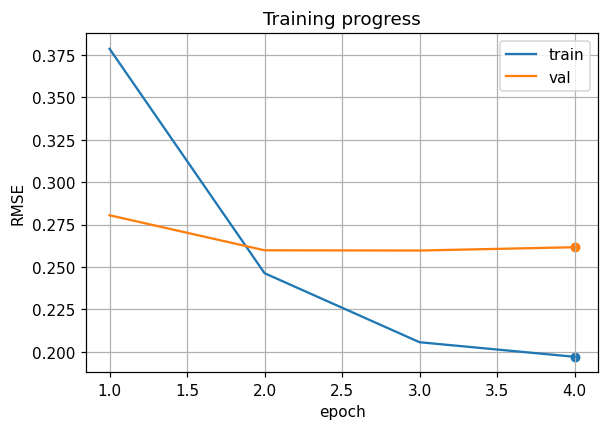

In [17]:

# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────
study = optuna.create_study(
    direction="minimize",
    pruner   = MedianPruner(n_startup_trials=5, n_warmup_steps=2),
)

study.optimize(
    objective_train,
    n_trials = 50,
    n_jobs   = 1,               # to run trials concurrently
    callbacks =[plots.live_plot_callback]
)

# ──────────────────────────────────────────────────────────────────────────────
# Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ------------------------------------------------------------------
# Build a dynamic file-name:  <results_folder>/<TICKER>_<YYYYMMDD>-<YYYYMMDD>_optuna.json
# ------------------------------------------------------------------

start_date  = df.index.min().strftime("%Y%m%d")  # ❹ first date in the DataFrame
end_date    = df.index.max().strftime("%Y%m%d")  # ❺ last  date in the DataFrame

file_name = f"{ticker}_{start_date}-{end_date}_optuna_hyperpars.json"
file_path = os.path.join(results_folder, file_name)

# ------------------------------------------------------------------
# Dump study results
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "trials": [
                {
                    "number" : t.number,
                    "value"  : t.value,
                    "params" : t.params,
                    "state"  : t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"Optuna results saved to: {file_path}")